## A First Taste of Applied Machine Learning

### Random Forest Regressor 

As a first example, let's train a random forest regressor (RFR) to predict apartment rent prices in New York City. For the data set see `data` directory and `rent_ideal.csv`. To train a model, we split the data frame into the feature columns (the predictors) and the target (predicted) column, which practitioners typically call variables X and y. Let's train a model using all apartment features to predict rent prices.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from rfpimp import *
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# sets the size of plots in inches (1 inch = 2.54cm)
plt.rcParams["figure.figsize"] = (20, 7)
# sets the theme for plots to dark
plt.style.use('dark_background')

# read the data set into pandas' data frame
rent = pd.read_csv('../data/rent-ideal.csv')

# show data frame
rent.head(7).T

,0,1,2,3,4,5,6
bedrooms,1.0000,2.0000,2.0000,3.0000,0.0000,3.0000,3.0000
bathrooms,1.0000,1.0000,1.0000,1.5000,1.0000,1.0000,2.0000
latitude,40.7108,40.7513,40.7575,40.7145,40.7439,40.7348,40.7302
longitude,-73.9539,-73.9722,-73.9625,-73.9425,-73.9743,-73.9865,-73.9826
price,2400.0000,3800.0000,3495.0000,3000.0000,2795.0000,7200.0000,6000.0000


Average rent is 3438.297950310559

   bathrooms        price
0        0.0  3144.870000
1        1.0  3027.007118
2        1.5  4226.336449
3        2.0  5278.595739
4        2.5  6869.047368
5        3.0  6897.974576
6        3.5  7635.357143
7        4.0  7422.888889
8        4.5  2050.000000
9       10.0  3600.000000


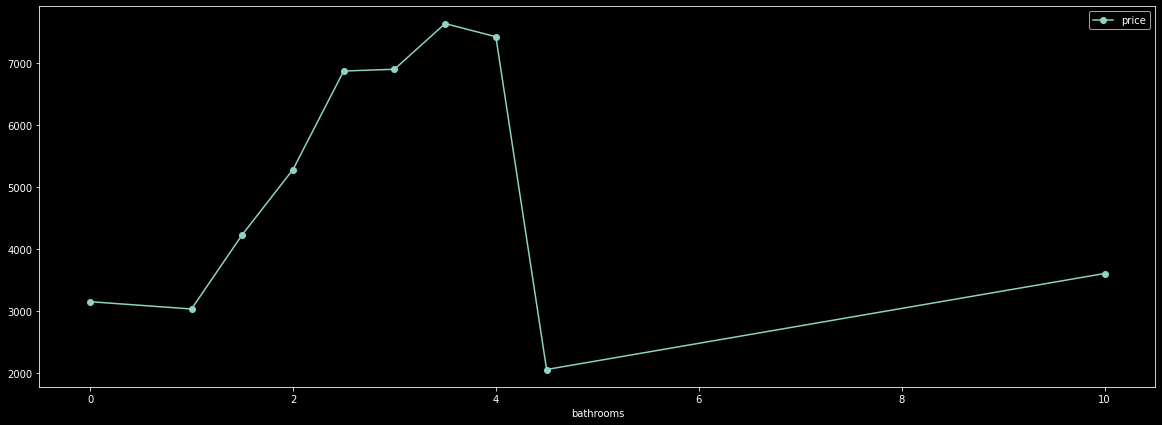

In [2]:
# mean value of price
average_rent = rent['price'].mean()

# mean value of price grouped by number of bathrooms
groupByBathrooms = rent.groupby('bathrooms').mean()
groupByBathrooms = groupByBathrooms[['price']].reset_index()

# show results
groupByBathrooms.plot.line('bathrooms', 'price', style='-o')
print(f'Average rent is {average_rent}\n')
print(groupByBathrooms)

In [3]:
# split data frame into features columns (predictors) and the target column (predicted value)
X, y = rent[['bedrooms','bathrooms','latitude','longitude']], rent['price']

# train a random forest model using features and target variable
model = RandomForestRegressor(n_estimators=10, n_jobs=-1)
model.fit(X, y)

# to test the model let's create some apartment vector
unknown_x = [2, 1, 40.7957, -73.97] # 2 bedrooms, 1 bathroom, ...

# we call predict() function on the model object in oder to make a prediction
model.predict([unknown_x]) # The model predicts rent of about $4510 given the apartment characteristics in unknown_x.

array([4352.49817057])

Once we've trained a model, we have to test it. There are two things to test. First, we verify that the model fits the training data well, meaning that the model captures the relationship in the training data between feature vectors and the targets. Second, we verify that the model generalizes, yielding reasonable rent predictions for feature vectors not in the training set.

To see how well the model fits the training data, we pass the feature vectors of the training data back into the model and compare the predictions to the known actual prices. At this point in our process, we don't care about generality. We're just checking that our model can reproduce the original training data with some degree of accuracy. If the model can't make accurate predictions for apartments it trained on, then there's no hope the model will generalize to previously-unseen apartments.

There are number of common error metrics that practitioners use, but in this case, measuring the average difference between predicted and actual prices is a good metric. In other words, we'll make a prediction for every apartment and subtract that from the actual price found in the training data (and take absolute value). The average of sum of those differences is the mean absolute error, abbreviated MAE.

$$MAE = \frac{\sum_{i=1}^{n}|predicted_i - actual_i|}{n}$$

In [4]:
# return training set back to the model (RFR)
predictions = model.predict(X)
# calculate |predicted - actual| for each apartment, sum that and average
error = mean_absolute_error(y, predictions)

# to test the regression fit to this data we compare total error of the model to the mean price
# this is because our model should not perform worse than just predicting the mean for every apartment
error_percentage = error*100.0/y.mean()

print(f"${error:.0f} average error; {error_percentage:.2f}% error percentage")

$190 average error; 5.52% error percentage


That means a user of this model can expect the predicted price for an apartment in the training data to be off by about $189, which is pretty good! We call this the training error.

They say that three most important property attributes in real estate are: location, location, location. Let's test that hypothesis with our rental data, using just the two columns associated with map location.

In [5]:
# new training set based just on location
X, y = rent[['latitude','longitude']], rent['price']

# new RF model
model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)

# calculate errors
error = mean_absolute_error(y, model.predict(X))
error_percentage = error*100.0/y.mean()

print(f"${error:.0f} average error; {error_percentage:.2f}% error")

$519 average error; 15.09% error


Using just the location, and no information about the number of bedrooms or bathrooms, the average prediction error on the training set is \$519. That's more than the error with all features (\$189) but is still not bad.

You might compare the difference between the 5.508% error for the model fit on all features and this 15.095% error and think "it's only 9%." It's better to think of this as the ratio 5.51/15.10 is 36% rather than the difference 5.51-15.10. The ratio indicates that dropping the number of bedrooms and bathrooms from the model reduces prediction accuracy by 36%. This information is extremely useful because it tells us something about the predictive power of those features.

Also, we shouldn't get too excited by the $189 training error because that just shows our model captures the relationships in the training data. We know nothing about the model's generality. The true measure of model quality is its generality: how accurately it predicts prices for apartment feature vectors not found in the training data. To test for model generality, we need a validation strategy. Let's use hold out method. The goal is to hold out, say, 20% of the training data, splitting the original data set into two: a smaller training set and a validation set. Validation set is data used only for generality testing of our model, not in training the model. Which 20% to hold out is sometimes nontrivial, but for the apartment data, a random subset is fine.

In [6]:
# extract X and y from rent data set
X, y = rent[['bedrooms','bathrooms','latitude','longitude']], rent['price']

# 20% of data goes into test set, 80% into training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# build model
model = RandomForestRegressor(n_estimators=10, n_jobs=-1)
model.fit(X_train, y_train)

# calculate MAE
validation_error = mean_absolute_error(y_test, model.predict(X_test))
print(f"${validation_error:.0f} average error; {validation_error*100.0/y.mean():.2f}% error")

$307 average error; 8.94% error


Now that we have a metric of model generality (\$303 average error and 8.81% error), we can use it to tweak model architecture in an effort to improve accuracy. The idea is to wiggle some aspect(s) of the model and see if the validation error goes up or down. For example, the number of trees in our forest affects accuracy and so let's increase the number of trees to 100 from 10. The number of trees, and any other aspect of the model that affects its architecture, statisticians call a **hyper-parameter**.

In [7]:
# new model with 100 regression trees
model = RandomForestRegressor(n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

validation_error = mean_absolute_error(y_test, model.predict(X_test))
print(f"${validation_error:.0f} average error; {validation_error*100.0/y.mean():.2f}% error")

$301 average error; 8.76% error


#### What the model says about the data

Machine learning models do much more for us than make predictions. Depending on the model, we can learn quite a bit about the data itself. More generally, we'd like to know which features have the most predictive power.

In [8]:
# caclulate the feature importances
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

importances_ = importances(model, X_test, y_test)
importances_

,Importance
Feature,
bedrooms,0.541995
longitude,0.522206
latitude,0.428446
bathrooms,0.422593


Notice that the RF model is trained using the training set, but the importances are computed using the validation set. Feature importances, therefore, measure the drop in the model's validation set accuracy when each feature is removed (or randomly permuted). It makes sense to examine the predictive power of features in this context because we care most about how well a model generalizes to test vectors outside of the training set.

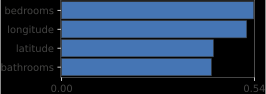

In [9]:
plot_importances(importances_, color='#4575b4', vscale=1.8)

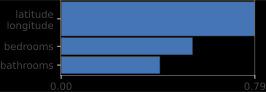

In [10]:
# we can group latitude and longitude together as a meta-feature when computing feature importances
imp = importances(model, X_test, y_test, features=['bedrooms','bathrooms',['latitude','longitude']])
plot_importances(imp, color='#4575b4', vscale=1.8)

From this, we can conclude that New Yorkers care the least about bathrooms because that feature has the least predictive power compared to the other features. Together, latitude and longitude have a great deal of predictive power.

### Random Forest Classifier

To build our first classifier, we're going to train a model using the well-known **Wisconsin Breast Cancer** data set. **Sklearn** library will provide data set for this model.

In [11]:
from sklearn.datasets import load_breast_cancer

# load data
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target
df = pd.DataFrame(X, columns=cancer.feature_names)

In [12]:
# turns out that these few features are the ones which matter
features = ['radius error', 'texture error', 'concave points error',
            'symmetry error', 'worst texture', 'worst smoothness',
            'worst symmetry']

# select just these features
df = df[features]

# show 30 values of malignant/benign target
print("target[0:30] =", y[0:30])
df.head()

target[0:30] = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0]


,radius error,texture error,concave points error,symmetry error,worst texture,worst smoothness,worst symmetry
0,1.0950,0.9053,0.01587,0.03003,17.33,0.1622,0.4601
1,0.5435,0.7339,0.01340,0.01389,23.41,0.1238,0.2750
2,0.7456,0.7869,0.02058,0.02250,25.53,0.1444,0.3613
3,0.4956,1.1560,0.01867,0.05963,26.50,0.2098,0.6638
4,0.7572,0.7813,0.01885,0.01756,16.67,0.1374,0.2364


In [13]:
# train the model
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.15)

classifier = RandomForestClassifier(n_estimators=300, n_jobs=-1)
classifier.fit(X_train, y_train)

# calculate the model
validation_error = classifier.score(X_test, y_test)
print(f"{validation_error*100:.2f}% correct accuracy")

88.37% correct accuracy


For classifiers, the `score()` function returns the simplest metric for correctness (accuracy), which measures how many the model predicted correctly out of 569 observations divided by 569. We can compute feature importances for classifiers just as we did for regressors. (In fact we can compute feature importances for any model.) In this case, we see that radius error is the most important feature for distinguishing between malignant versus benign masses based upon these 7 features.

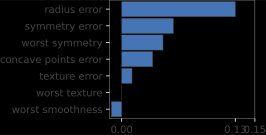

In [14]:
imp = importances(classifier, X_test, y_test)
plot_importances(imp, color='#4575b4', vscale=1.4)

Such feature importance graphs suggest which cell characteristics pathologist should focus on. At this point, we've trained both a regressor and a classifier on structured data. Structured data is what we normally see in spreadsheets or database tables. Unstructured data sets, on the other hand, contain things like images, documents, and tweets. As a general rule, neural networks should be used for unstructured data.